In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft


sns.set_theme()
sns.set_palette("deep")

# Пример

## Параметры установки

In [3]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
mass_proton_kg = 1.67252 * 10**(-24) # тоже самое только в кг (но нужно проверить)
mass_neutron = 938.2 * 10**6 # масса покоя нейрона 
mass_electron = 0.5111006 * 10**6 # масса покоя электрона
mass_electron_kg = 9.109383 * 10**(-28) # масса электрона кг

charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл 
e_conv = 299.7925 # ПОСМОТРЕТЬ (коэф перевода )
charge_electron_sgs = 4.80298 * 10*(-10) # заряд электрона СГС 

charge_number = 28 # зарядовое число 
mass_number = 124 # массовое число
booster_perimeter = 21096 # периметр бустера в мм

radius_proton  = (e_conv * charge_electron_sgs) / mass_proton # радиус протона 
radius_electron = (charge_electron_sgs * e_conv) / mass_electron # радиус электрона

phase = 1.38054 * 10**(-16) # ----
Z_n = 377 # --- 
speed_of_light = 2.997925 * 10**10

## Чтение данных

In [36]:
booster_fct_path = r'../data/booster_acceleration/1/27_01_23_booster_fct_1.bin'
booster_rf_path = r'../data/booster_acceleration/1/27_01_23_booster_rf_1.bin'

In [76]:
data_length = 7 * 32 * 128 * 1024
delta_time = (50 * 10e5)**(-1)

offset_fct = 45 # сдвиг начала 
offset_rf = 10     
shift_periods_number = 1500 # сдвиг конца
injection_period = 425.067 # период на энжекции (период можно высчетать как в прошлом файле)

number_period = np.floor(data_length / injection_period)

In [77]:
signal_fct = np.fromfile(booster_fct_path, dtype='int16')[:data_length+1]
signal_rf = np.fromfile(booster_rf_path, dtype='int16')[:data_length+1]

## Построение графиков

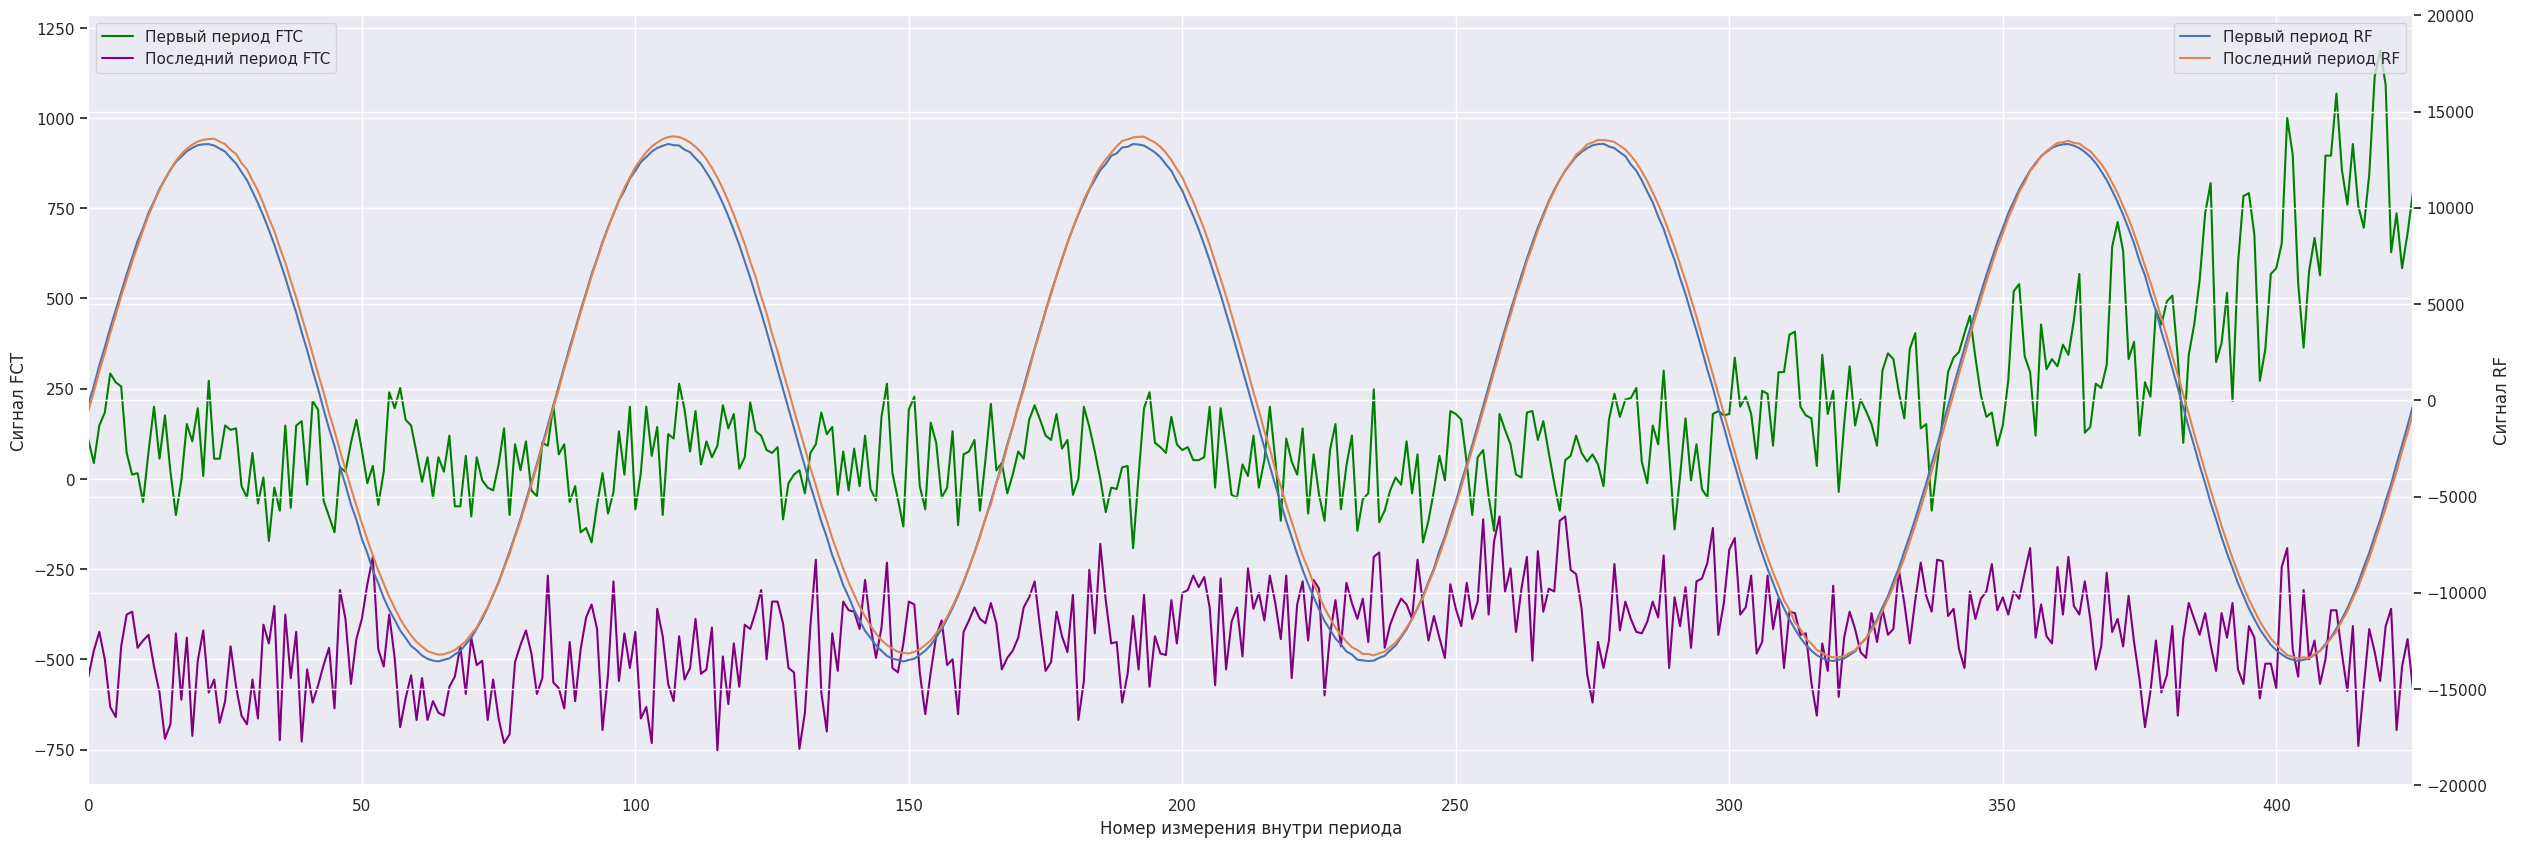

In [93]:
injection_period_range = np.arange(injection_period, dtype=int)

slice_start_fct = injection_period_range + offset_fct
slice_last_fct = offset_fct + injection_period_range + int(shift_periods_number * injection_period)

slice_start_rf = injection_period_range + offset_rf
slice_last_rf = offset_rf + injection_period_range + int(shift_periods_number * injection_period)

fig = plt.figure(figsize=(30, 10))

plt.plot(injection_period_range, signal_fct[slice_start_fct], color='green', label='Первый период FTC')
plt.plot(injection_period_range, signal_fct[slice_last_fct], color='purple', label='Последний период FTC')
plt.ylabel('Сигнал FCT')
plt.xlabel('Номер измерения внутри периода')
plt.legend()

plt.twinx()

plt.plot(injection_period_range, signal_rf[slice_start_rf], label='Первый период RF')
plt.plot(injection_period_range, signal_rf[slice_last_rf], label='Последний период RF')
plt.ylabel('Сигнал RF')
plt.legend()

# Прост чтобы на графике было меньше пустых областей
plt.xlim([0, injection_period])
plt.ylim([-2*10**(4), 2*10**4]);

In [98]:
def find_P_b_matrix(phase, period): #  пока оставить -----
    P_b = np.zeros((3, 3))
    cos_vals = np.cos(phase * np.arange(np.ceil(period)))
    sin_vals = np.sin(phase * np.arange(np.ceil(period)))

    P_b[0, 0] = np.sum(cos_vals**2)
    P_b[0, 1] = cos_vals @ sin_vals
    P_b[0, 2] = np.sum(cos_vals)

    P_b[1, 0] = P_b[0, 1]
    P_b[1, 1] = np.sum(sin_vals**2)
    P_b[1, 2] = np.sum(sin_vals)
    
    P_b[2, 0] = P_b[0, 2]
    P_b[2, 1] = P_b[1, 2]
    P_b[2, 2] = period + 1

    return P_b

In [185]:
def zero_crossing(data, harmonic_HF, offset, start_period):
    n = offset
    iteration = 0
    period = start_period

    correlation_matrix  = []

    while n < (data.shape[0] - np.floor(period) - 1):

        phase = 2 * np.pi / period * harmonic_HF # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 

        period = int(period)

        harmonics_vector = np.zeros(3) # матрица гармоник от 0 до period 
        harmonics_vector[0] = np.sum(data[n:n + period + 1] * np.cos(phase * np.arange(period + 1)))
        harmonics_vector[1] = np.sum(data[n:n + period + 1] * np.sin(phase * np.arange(period + 1)))
        harmonics_vector[2] = np.sum(data[n:n + period + 1])

        P = find_P_b_matrix(phase, period)
        A = np.linalg.inv(P) @ harmonics_vector .T # ----

        correlation_vector = np.zeros(3) # матрица корреляций 
        correlation_vector[1] = np.sqrt(A[0]**2 + A[1]**2) # амплитуда 
        correlation_vector[0] = n + (1 / phase * np.arctan2(A[0], -A[1])) # фаза 
        correlation_vector[2] = A[2] # ----

        correlation_matrix.append(correlation_vector)

        n = int(np.floor(correlation_matrix[iteration][0] + period)) # перечет офсета 

        period = 1 / 10 * (correlation_matrix[iteration][0] - correlation_matrix[iteration-10][0]) if iteration > 12 else period # перечсет периода для окна 

        iteration += 1

    return np.array(correlation_matrix) 

In [186]:
harmonic_hf = 5 # назвать лучше h - гармоника ВЧ

In [187]:
result1 = zero_crossing(signal_rf, harmonic_hf, offset_rf, injection_period) # набор матриц корреляций 

In [160]:
injection_period

425.067

In [184]:
result = zero_crossing(signal_rf, harmonic_hf, offset_rf, injection_period) # набор матриц корреляций 
# correlation_matrix = np.array(result)

In [134]:
correlation_matrix.shape

(124483, 3)

In [137]:
np.empty((5, 3))

array([[880.        , 886.        , 880.        ],
       [880.        , 110.        , 880.        ],
       [872.36111111, 880.        , 880.        ],
       [880.        , 110.        , 880.        ],
       [872.36111111, 880.        , 886.        ]])